In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [17]:

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [18]:

class WaterQualityCorrelationAnalysis:
    """
    하천 수질 데이터 상관분석 클래스
    """
    
    def __init__(self, data_path=None, df=None):
        """
        초기화
        Args:
            data_path: Excel 파일 경로 (선택사항)
            df: 이미 로드된 DataFrame (선택사항)
        """
        if df is not None:
            self.df = df.copy()
        elif data_path:
            self.df = pd.read_excel(data_path)
        else:
            raise ValueError("data_path 또는 df 중 하나는 반드시 제공해야 합니다.")
        
        self.water_quality_params = []
        self.biological_params = []
        self.meteorological_params = []
        self.electrode_params = []
        
        self._categorize_parameters()
        self._preprocess_data()
    
    def _categorize_parameters(self):
        """
        측정 항목을 카테고리별로 분류
        """
        # 수질 관련 파라미터
        self.water_quality_params = [
            '수소이온농도', '용존산소', '전기전도도', '수온', 
            '총유기탄소', '총질소', '총인'
        ]
        
        # 생물학적 지표
        self.biological_params = [
            '클로로필-a', '남조류', '미생물 독성지수', '미생물 상태정보'
        ]
        
        # 전극 데이터
        self.electrode_params = ['전극[A]', '전극[B]']
        
        # 기상 데이터 (접두사 제거하여 정리)
        meteorological_columns = [col for col in self.df.columns if col.startswith('기상_')]
        self.meteorological_params = meteorological_columns
        
        print(f"수질 파라미터: {len(self.water_quality_params)}개")
        print(f"생물학적 지표: {len(self.biological_params)}개") 
        print(f"전극 데이터: {len(self.electrode_params)}개")
        print(f"기상 데이터: {len(self.meteorological_params)}개")
    
    def _preprocess_data(self):
        """
        데이터 전처리
        """
        # 측정시간을 datetime으로 변환
        if '측정시간' in self.df.columns:
            self.df['측정시간'] = pd.to_datetime(self.df['측정시간'])
        
        # 수치형 데이터만 추출 (문자열 및 빈 값 제거)
        numeric_columns = self.water_quality_params + self.biological_params + \
                         self.electrode_params + self.meteorological_params
        
        # 존재하는 컬럼만 선택
        existing_columns = [col for col in numeric_columns if col in self.df.columns]
        self.df_numeric = self.df[existing_columns].copy()
        
        # 문자열을 숫자로 변환 (빈 문자열은 NaN으로)
        for col in self.df_numeric.columns:
            self.df_numeric[col] = pd.to_numeric(self.df_numeric[col], errors='coerce')
        
        print(f"\n전처리 완료:")
        print(f"분석 대상 컬럼: {len(self.df_numeric.columns)}개")
        print(f"데이터 행 수: {len(self.df_numeric)}개")
        print(f"결측값 현황:")
        missing_data = self.df_numeric.isnull().sum()
        print(missing_data[missing_data > 0])
    
    def calculate_correlations(self, method='pearson'):
        """
        상관계수 계산
        Args:
            method: 상관계수 방법 ('pearson', 'spearman', 'kendall')
        """
        print(f"\n=== {method.upper()} 상관계수 분석 ===")
        
        # 전체 상관계수 매트릭스
        self.correlation_matrix = self.df_numeric.corr(method=method)
        
        # 카테고리별 상관분석 결과 저장
        self.correlation_results = {}
        
        # 1. 수질 지표 간 상관관계
        wq_params = [p for p in self.water_quality_params if p in self.df_numeric.columns]
        if len(wq_params) > 1:
            self.correlation_results['수질_지표_간'] = self.df_numeric[wq_params].corr(method=method)
        
        # 2. 수질 지표 vs 생물학적 지표
        bio_params = [p for p in self.biological_params if p in self.df_numeric.columns]
        if wq_params and bio_params:
            self.correlation_results['수질_vs_생물학적'] = self.df_numeric[wq_params + bio_params].corr(method=method)
        
        # 3. 기상 데이터 vs 수질 지표
        met_params = [p for p in self.meteorological_params if p in self.df_numeric.columns]
        if wq_params and met_params:
            self.correlation_results['기상_vs_수질'] = self.df_numeric[met_params + wq_params].corr(method=method)
        
        # 4. 기상 데이터 vs 생물학적 지표
        if met_params and bio_params:
            self.correlation_results['기상_vs_생물학적'] = self.df_numeric[met_params + bio_params].corr(method=method)
        
        return self.correlation_matrix
    
    def analyze_significant_correlations(self, threshold=0.3, p_value_threshold=0.05):
        """
        통계적으로 유의한 상관관계 분석
        Args:
            threshold: 상관계수 임계값 (절댓값)
            p_value_threshold: p-value 임계값
        """
        print(f"\n=== 유의한 상관관계 분석 (|r| > {threshold}, p < {p_value_threshold}) ===")
        
        significant_correlations = []
        
        # 모든 변수 쌍에 대해 검사
        columns = self.df_numeric.columns
        for i, col1 in enumerate(columns):
            for j, col2 in enumerate(columns):
                if i < j:  # 중복 제거
                    # 결측값 제거
                    valid_data = self.df_numeric[[col1, col2]].dropna()
                    
                    if len(valid_data) > 3:  # 최소 4개의 관측값 필요
                        corr_coef, p_value = stats.pearsonr(valid_data[col1], valid_data[col2])
                        
                        if abs(corr_coef) > threshold and p_value < p_value_threshold:
                            significant_correlations.append({
                                '변수1': col1,
                                '변수2': col2,
                                '상관계수': corr_coef,
                                'p_value': p_value,
                                '표본수': len(valid_data),
                                '강도': self._interpret_correlation_strength(abs(corr_coef))
                            })
        
        # DataFrame으로 변환 및 정렬
        self.significant_corr_df = pd.DataFrame(significant_correlations)
        if not self.significant_corr_df.empty:
            self.significant_corr_df = self.significant_corr_df.sort_values('상관계수', key=abs, ascending=False)
            
            print(f"발견된 유의한 상관관계: {len(self.significant_corr_df)}개")
            print("\n상위 10개 상관관계:")
            display_df = self.significant_corr_df.head(10).copy()
            display_df['상관계수'] = display_df['상관계수'].round(3)
            display_df['p_value'] = display_df['p_value'].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}")
            print(display_df.to_string(index=False))
        else:
            print("지정된 기준을 만족하는 유의한 상관관계가 없습니다.")
        
        return self.significant_corr_df
    
    def _interpret_correlation_strength(self, corr_abs):
        """상관계수 강도 해석"""
        if corr_abs >= 0.8:
            return "매우 강함"
        elif corr_abs >= 0.6:
            return "강함"
        elif corr_abs >= 0.4:
            return "보통"
        elif corr_abs >= 0.2:
            return "약함"
        else:
            return "매우 약함"
    
    def categorize_correlations_by_type(self):
        """
        상관관계를 유형별로 분류하여 분석
        """
        print("\n=== 상관관계 유형별 분석 ===")
        
        if not hasattr(self, 'significant_corr_df') or self.significant_corr_df.empty:
            print("먼저 analyze_significant_correlations()를 실행하세요.")
            return
        
        correlation_types = {
            '수질_지표_간': {'수질': self.water_quality_params},
            '생물학적_지표_간': {'생물학적': self.biological_params},
            '기상_데이터_간': {'기상': self.meteorological_params},
            '수질_vs_생물학적': {'수질': self.water_quality_params, '생물학적': self.biological_params},
            '수질_vs_기상': {'수질': self.water_quality_params, '기상': self.meteorological_params},
            '생물학적_vs_기상': {'생물학적': self.biological_params, '기상': self.meteorological_params}
        }
        
        categorized_results = {}
        
        for category, param_groups in correlation_types.items():
            category_correlations = []
            
            for _, row in self.significant_corr_df.iterrows():
                var1, var2 = row['변수1'], row['변수2']
                
                # 카테고리에 따른 분류 로직
                if len(param_groups) == 1:  # 같은 카테고리 내 상관관계
                    category_name = list(param_groups.keys())[0]
                    if var1 in param_groups[category_name] and var2 in param_groups[category_name]:
                        category_correlations.append(row)
                else:  # 다른 카테고리 간 상관관계
                    cat1, cat2 = list(param_groups.keys())
                    if ((var1 in param_groups[cat1] and var2 in param_groups[cat2]) or
                        (var1 in param_groups[cat2] and var2 in param_groups[cat1])):
                        category_correlations.append(row)
            
            if category_correlations:
                categorized_results[category] = pd.DataFrame(category_correlations)
                print(f"\n{category}: {len(category_correlations)}개")
                for _, corr in pd.DataFrame(category_correlations).head(3).iterrows():
                    print(f"  {corr['변수1']} ↔ {corr['변수2']}: r={corr['상관계수']:.3f} ({corr['강도']})")
        
        self.categorized_correlations = categorized_results
        return categorized_results
    
    def plot_correlation_heatmap(self, category='전체', figsize=(15, 12), annot=True):
        """
        상관계수 히트맵 시각화
        Args:
            category: 시각화할 카테고리 ('전체', '수질_지표_간', '수질_vs_생물학적', 등)
            figsize: 그래프 크기
            annot: 상관계수 수치 표시 여부
        """
        if category == '전체':
            corr_matrix = self.correlation_matrix
            title = "전체 측정항목 상관관계 히트맵"
        elif category in self.correlation_results:
            corr_matrix = self.correlation_results[category]
            title = f"{category} 상관관계 히트맵"
        else:
            print(f"사용 가능한 카테고리: 전체, {', '.join(self.correlation_results.keys())}")
            return
        
        plt.figure(figsize=figsize)
        
        # 히트맵 생성
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각 마스크
        sns.heatmap(corr_matrix, 
                   mask=mask,
                   annot=annot, 
                   cmap='RdBu_r', 
                   center=0,
                   square=True, 
                   fmt='.2f',
                   cbar_kws={'label': 'Correlation Coefficient'})
        
        plt.title(title, fontsize=16, pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def plot_scatter_matrix(self, variables=None, sample_size=None):
        """
        산점도 매트릭스 생성
        Args:
            variables: 분석할 변수 리스트 (None이면 주요 변수들 자동 선택)
            sample_size: 표본 크기 (None이면 전체 데이터 사용)
        """
        if variables is None:
            # 주요 변수들 자동 선택 (결측값이 적은 순으로)
            missing_counts = self.df_numeric.isnull().sum()
            variables = missing_counts.sort_values().head(8).index.tolist()
        
        plot_data = self.df_numeric[variables].dropna()
        
        if sample_size and len(plot_data) > sample_size:
            plot_data = plot_data.sample(n=sample_size, random_state=42)
        
        # 산점도 매트릭스 생성
        fig, axes = plt.subplots(len(variables), len(variables), 
                                figsize=(15, 15))
        
        for i, var1 in enumerate(variables):
            for j, var2 in enumerate(variables):
                ax = axes[i, j]
                
                if i == j:
                    # 대각선: 히스토그램
                    ax.hist(plot_data[var1], bins=20, alpha=0.7, color='skyblue')
                    ax.set_ylabel('빈도')
                else:
                    # 비대각선: 산점도
                    ax.scatter(plot_data[var2], plot_data[var1], alpha=0.5, s=10)
                    
                    # 상관계수 표시
                    corr = plot_data[var1].corr(plot_data[var2])
                    ax.text(0.05, 0.95, f'r={corr:.2f}', 
                           transform=ax.transAxes, fontsize=10,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                
                # 축 레이블
                if i == len(variables) - 1:
                    ax.set_xlabel(var2, rotation=45, ha='right')
                if j == 0:
                    ax.set_ylabel(var1)
                
                # 축 눈금 조정
                ax.tick_params(axis='both', which='major', labelsize=8)
        
        plt.suptitle('주요 측정항목 산점도 매트릭스', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def generate_correlation_report(self, output_file=None):
        """
        상관분석 결과 종합 보고서 생성
        Args:
            output_file: 저장할 파일명 (None이면 화면 출력만)
        """
        report = []
        report.append("=" * 60)
        report.append("하천 수질 데이터 상관분석 보고서")
        report.append("=" * 60)
        
        # 데이터 개요
        report.append(f"\n1. 데이터 개요")
        if '측정시간' in self.df.columns:
            report.append(f"   - 분석 기간: {self.df['측정시간'].min()} ~ {self.df['측정시간'].max()}")
        else:
            report.append("   - 분석 기간: (측정시간 정보 없음)")
        report.append(f"   - 총 데이터 수: {len(self.df)}개")
        report.append(f"   - 분석 변수 수: {len(self.df_numeric.columns)}개")
        
        # 주요 발견사항
        if hasattr(self, 'significant_corr_df') and not self.significant_corr_df.empty:
            report.append(f"\n2. 주요 발견사항")
            report.append(f"   - 통계적으로 유의한 상관관계: {len(self.significant_corr_df)}개")
            
            # 가장 강한 양의 상관관계
            positive_corr = self.significant_corr_df[self.significant_corr_df['상관계수'] > 0]
            if not positive_corr.empty:
                strongest_pos = positive_corr.iloc[0]
                report.append(f"   - 가장 강한 양의 상관관계: {strongest_pos['변수1']} ↔ {strongest_pos['변수2']} (r={strongest_pos['상관계수']:.3f})")
            
            # 가장 강한 음의 상관관계
            negative_corr = self.significant_corr_df[self.significant_corr_df['상관계수'] < 0]
            if not negative_corr.empty:
                strongest_neg = negative_corr.loc[negative_corr['상관계수'].idxmin()]
                report.append(f"   - 가장 강한 음의 상관관계: {strongest_neg['변수1']} ↔ {strongest_neg['변수2']} (r={strongest_neg['상관계수']:.3f})")
        
        # 카테고리별 요약
        if hasattr(self, 'categorized_correlations'):
            report.append(f"\n3. 카테고리별 상관관계")
            for category, corr_df in self.categorized_correlations.items():
                report.append(f"   - {category}: {len(corr_df)}개")
                if len(corr_df) > 0:
                    avg_corr = corr_df['상관계수'].abs().mean()
                    report.append(f"     평균 상관계수 강도: {avg_corr:.3f}")
        
        # 추천사항
        report.append(f"\n4. 분석 추천사항")
        report.append(f"   - 수질 관리를 위한 핵심 모니터링 지표 식별")
        report.append(f"   - 기상 조건이 수질에 미치는 영향 패턴 활용")
        report.append(f"   - 생물학적 지표와 화학적 지표의 연계 모니터링")
        report.append(f"   - 상관관계 기반 조기 경보 시스템 구축 검토")
        
        report_text = "\n".join(report)
        
        if output_file:
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(report_text)
            print(f"보고서가 {output_file}에 저장되었습니다.")
        else:
            print(report_text)
        
        return report_text


In [19]:

# 사용 예시 및 실행 함수
def run_complete_analysis(data_path=None, df=None):
    """
    완전한 상관분석 실행
    Args:
        data_path: Excel 파일 경로
        df: 이미 로드된 DataFrame
    """
    print("하천 수질 데이터 상관분석을 시작합니다...")
    
    # 분석 객체 생성
    analyzer = WaterQualityCorrelationAnalysis(data_path=data_path, df=df)
    
    # 1. 기본 상관계수 계산
    analyzer.calculate_correlations(method='pearson')
    
    # 2. 통계적으로 유의한 상관관계 분석
    analyzer.analyze_significant_correlations(threshold=0.3, p_value_threshold=0.05)
    
    # 3. 카테고리별 분류
    analyzer.categorize_correlations_by_type()
    
    # 4. 시각화
    print("\n히트맵을 생성합니다...")
    analyzer.plot_correlation_heatmap(category='전체', figsize=(12, 10))
    
    # 5. 주요 변수들의 산점도 매트릭스
    print("\n산점도 매트릭스를 생성합니다...")
    analyzer.plot_scatter_matrix(sample_size=200)
    
    # 6. 보고서 생성
    print("\n분석 보고서를 생성합니다...")
    analyzer.generate_correlation_report()
    
    return analyzer

# 실행 방법:
# 1. Excel 파일로부터 실행
# analyzer = run_complete_analysis(data_path='용봉측정소_24012506월_sample.xlsx')

# 2. 이미 로드된 DataFrame으로 실행
# analyzer = run_complete_analysis(df=your_dataframe)


하천 수질 데이터 상관분석을 시작합니다...
수질 파라미터: 7개
생물학적 지표: 4개
전극 데이터: 2개
기상 데이터: 15개

전처리 완료:
분석 대상 컬럼: 28개
데이터 행 수: 13128개
결측값 현황:
수소이온농도              647
용존산소                646
전기전도도               647
수온                  647
총유기탄소              1711
총질소                2145
총인                 1853
클로로필-a              455
남조류                 468
미생물 독성지수           1908
미생물 상태정보           1893
전극[A]              1908
전극[B]              1908
기상_2.기온(°C)           1
기상_2.강수량(mm)      11596
기상_2.강수량(일누적)         1
기상_2.풍속(m/s)         19
기상_2.풍향(16방위)        19
기상_2.습도(%)            1
기상_2.증기압(hPa)         1
기상_2.이슬점온도(°C)        1
기상_2.현지기압(hPa)        1
기상_2.해면기압(hPa)        1
기상_2.일조(hr)        5981
기상_2.일조(누적)           4
기상_2.일사(MJ/m2)     5981
기상_2.일사(누적)           4
기상_2.지면온도(°C)         1
dtype: int64

=== PEARSON 상관계수 분석 ===

=== 유의한 상관관계 분석 (|r| > 0.3, p < 0.05) ===
발견된 유의한 상관관계: 89개

상위 10개 상관관계:
           변수1            변수2  상관계수  p_value   표본수    강도
기상_2.현지기압(hPa) 기상_2.해면기압(hPa) 1.000 0.0

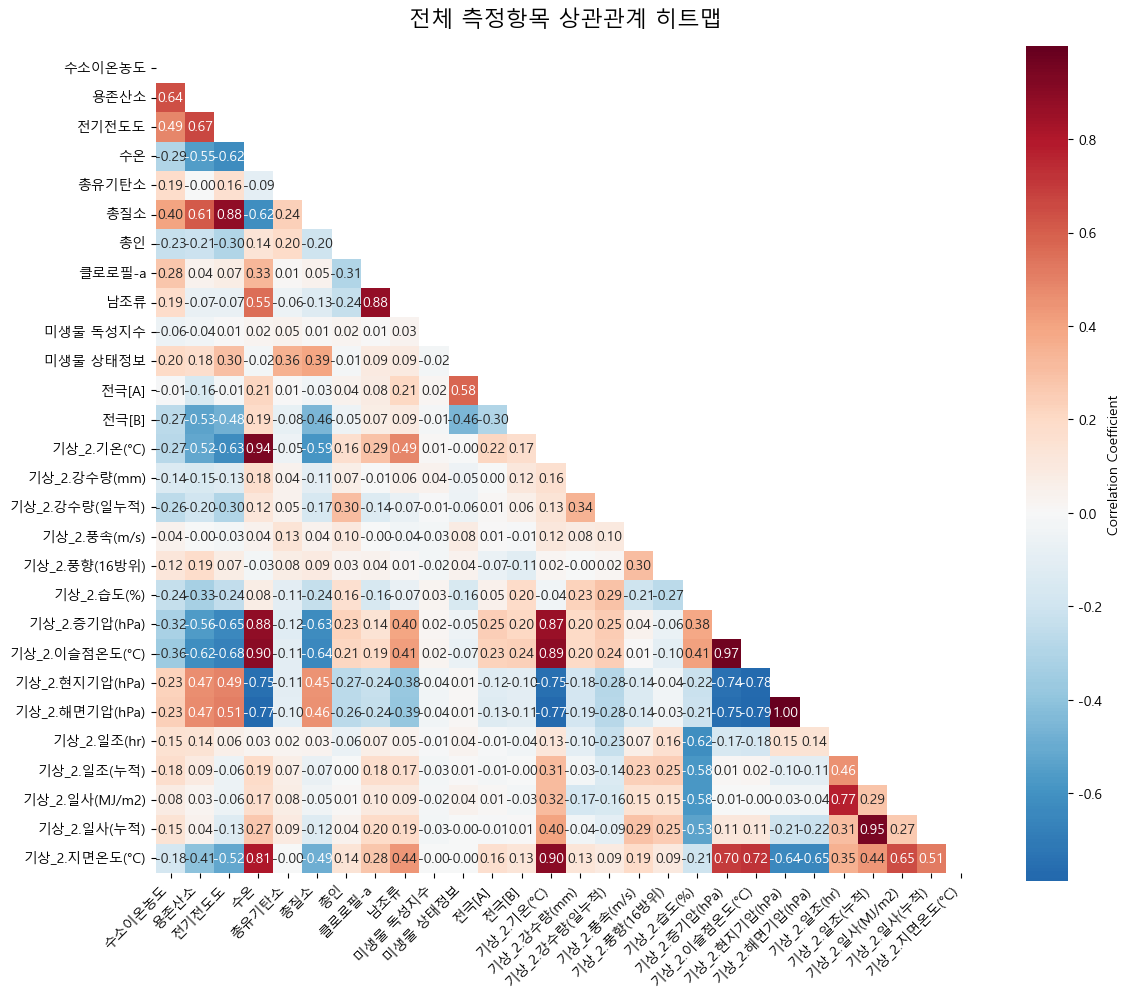


산점도 매트릭스를 생성합니다...


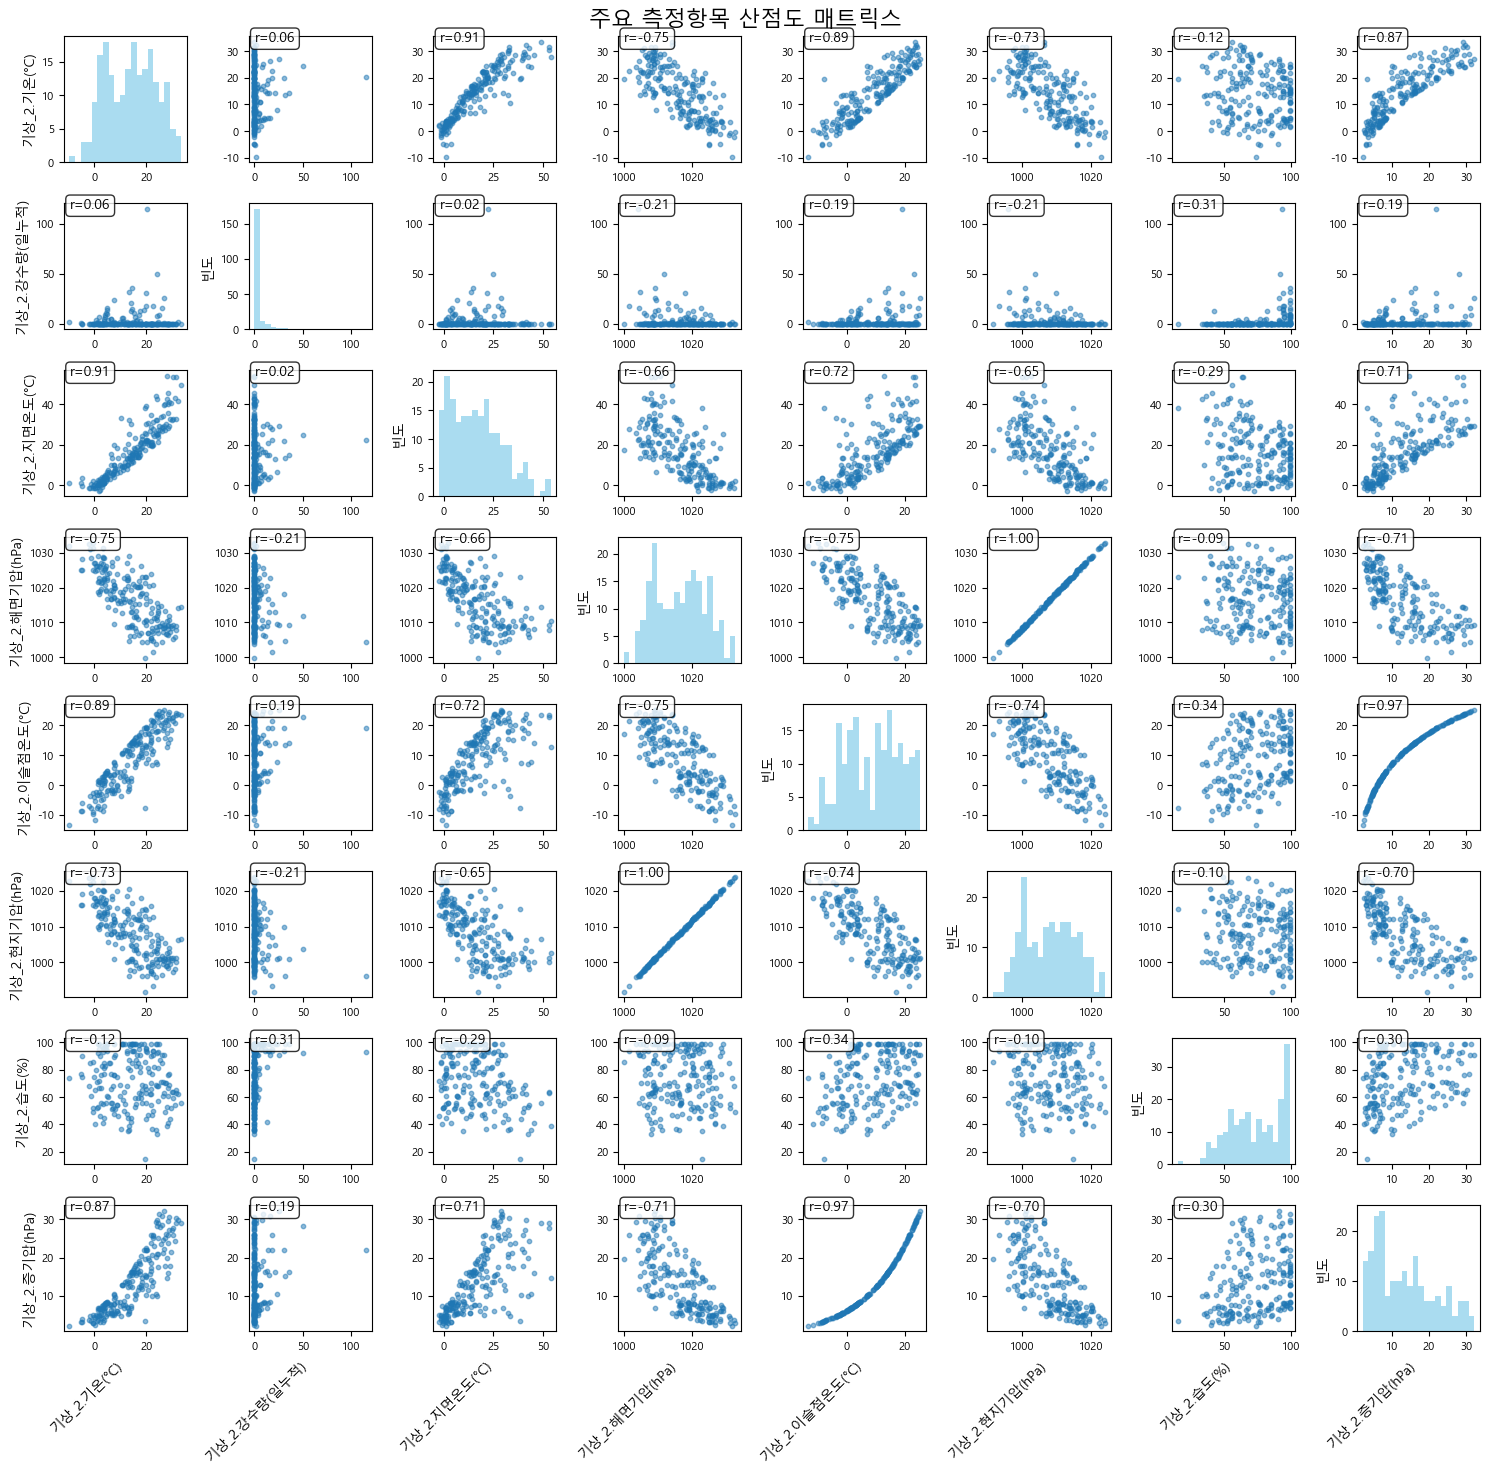


분석 보고서를 생성합니다...
하천 수질 데이터 상관분석 보고서

1. 데이터 개요
   - 분석 기간: (측정시간 정보 없음)
   - 총 데이터 수: 13128개
   - 분석 변수 수: 28개

2. 주요 발견사항
   - 통계적으로 유의한 상관관계: 89개
   - 가장 강한 양의 상관관계: 기상_2.현지기압(hPa) ↔ 기상_2.해면기압(hPa) (r=1.000)
   - 가장 강한 음의 상관관계: 기상_2.이슬점온도(°C) ↔ 기상_2.해면기압(hPa) (r=-0.788)

3. 카테고리별 상관관계
   - 수질_지표_간: 10개
     평균 상관계수 강도: 0.578
   - 생물학적_지표_간: 1개
     평균 상관계수 강도: 0.877
   - 기상_데이터_간: 34개
     평균 상관계수 강도: 0.622
   - 수질_vs_생물학적: 5개
     평균 상관계수 강도: 0.389
   - 수질_vs_기상: 28개
     평균 상관계수 강도: 0.576
   - 생물학적_vs_기상: 6개
     평균 상관계수 강도: 0.417

4. 분석 추천사항
   - 수질 관리를 위한 핵심 모니터링 지표 식별
   - 기상 조건이 수질에 미치는 영향 패턴 활용
   - 생물학적 지표와 화학적 지표의 연계 모니터링
   - 상관관계 기반 조기 경보 시스템 구축 검토


In [20]:
analyzer = run_complete_analysis(data_path=r'C.수질측정정보\용봉측정소_2401-2506월.xlsx')

In [21]:

if __name__ == "__main__":
    print("하천 수질 데이터 상관분석 모듈이 로드되었습니다.")
    print("사용법:")
    print(r"1. analyzer = run_complete_analysis(data_path='C.수질측정정보\용봉측정소_2401-2506월.xlsx')")
    # print("2. analyzer = run_complete_analysis(df=데이터프레임)")

하천 수질 데이터 상관분석 모듈이 로드되었습니다.
사용법:
1. analyzer = run_complete_analysis(data_path='C.수질측정정보\용봉측정소_2401-2506월.xlsx')
